### DATA620 - Week5, Part 2
#### Michael Ippolito
6/30/2022

It can be useful to be able to classify new "test" documents using already classified "training" documents.  A common example is using a corpus of labeled spam and ham (non-spam) e-mails to predict whether or not a new document is spam.  Here is one example of such data:  UCI Machine Learning Repository: Spambase Data Set
For this project, you can either use the above dataset to predict the class of new documents (either withheld from the training dataset or from another source such as your own spam folder).
For more adventurous students, you are welcome (encouraged!) to come up a different set of documents (including scraped web pages!?) that have already been classified (e.g. tagged), then analyze these documents to predict how new documents should be classified.

This assignment is due end of day on Sunday.

NOTE: This is a two week assignment.

### Link to video presentation

[Video](https://github.com/mmippolito/cuny_data620_week5_part2/blob/main/ippolito_video.mp4?raw=true)

In [2]:
# Load libraries
import matplotlib.pyplot as plt
import csv
import os
import requests
import numpy as np
from scipy import stats
import pandas as pd
from collections import Counter
import plotly.express as px
import plotly.io as pio
from nltk.corpus import names
from nltk.classify import apply_features
from nltk.metrics import ConfusionMatrix, precision, recall
import nltk
import random
import math
import collections

# Set module options
pio.renderers.default = 'jupyterlab'    # Set ploty renderer so graphs show up in HTML output
pd.set_option('display.width', 160)    # Set pandas display options


### Fetch Data

First, fetch the data from github if it already isn't on the local drive.


In [3]:
# Fetch data from github; source: https://github.com/t-davidson/hate-speech-and-offensive-language

# Fetch data from github repo and store in current directory
def fetch_data(fn, url):
    if not os.path.exists('hate_speech_labeled_data.csv'):
        print('Downloading', fn)
        try:
            r = requests.get(url).text
            fh = open(fn, 'w', encoding='utf-8')
            fh.write(r)
            fh.close()
        except:
            return 1
    else:
        print('CSV already exists on disk')
    return 0

# Fetch data
fn = 'hate_speech_labeled_data.csv'
url = 'https://github.com/t-davidson/hate-speech-and-offensive-language/blob/master/data/labeled_data.csv?raw=true'
err = fetch_data(fn, url)
if err > 0:
    assert(False, 'An error occured trying to download or save the csv.')

# Load csv into pandas dataframe
df1 = pd.read_csv(fn)

# Convert labels to text
df1.loc[df1['class'] == 0, 'label'] = 'hate_speech'
df1.loc[df1['class'] == 1, 'label'] = 'offensive_language'
df1.loc[df1['class'] == 2, 'label'] = 'neither'


CSV already exists on disk


Readme from github repo (https://github.com/t-davidson/hate-speech-and-offensive-language):

The data are stored as a CSV and as a pickled pandas dataframe (Python 2.7). Each data file contains 5 columns:
* count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).
* hate_speech = number of CF users who judged the tweet to be hate speech.
* offensive_language = number of CF users who judged the tweet to be offensive.
* neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.
* class = class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither


### Exploratory Data Analysis

Perform exploratory data analysis.


Column info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
 7   label               24783 non-null  object
dtypes: int64(6), object(2)
memory usage: 1.5+ MB
None

Summary stats:
         Unnamed: 0         count   hate_speech  offensive_language       neither         class
count  24783.000000  24783.000000  24783.000000        24783.000000  24783.000000  24783.000000
mean   12681.192027      3.243473      0.280515            2.413711      0.549247      1.110277
std     7299.553863      0.883060      0

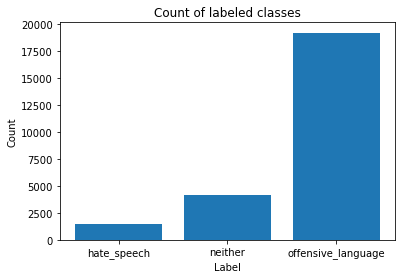

In [4]:
# EDA

# Display info about the data
print('Column info:')
print(df1.info())
print()
print('Summary stats:')
print(df1.describe())
print()
print('First few observations:')
print(df1.head())

# Bar chart of labeled classes
dfgrp = df1.groupby(['label'], as_index=False).count()
print()
plt.bar(x=dfgrp['label'], height=dfgrp['count'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Count of labeled classes')
plt.show()


As illustrated by the bar chart, the data is unbalanced heavily in favour of offensive language. This indicates that accuracy will most likely not be the best measure of model performance, and/or that either oversampling or understampling might be in order. In this case, we don't want to lose any data, so we'll reject undersampling of the majority class. And to avoid overfitting, we'll also reject oversampling the minority classes. Instead, we'll use alternate metrics (precision, recall, F1-score).


### Create Corpus

Create a corpus, i.e. an array of documents, which will be a list of tuples containing the text of the tweet and the corresponding label for that text. Then we'll tokenize the corpus using a naive approach, i.e. a simple word tokenizer using NLTK's built-in word_tokenize function.


In [5]:
# Create document array, which will be a list of tuples (text, label)
all_labels = list(df1['label'])
all_texts = list(df1['tweet'])
documents = []
for i, text in enumerate(all_texts):
    documents.append((text.split(), all_labels[i]))
random.shuffle(documents)
print('First few documents:')
print(documents[:5])


First few documents:
[(['"You', 'look', 'like', 'little', 'birds', 'help', 'you', 'get', 'dressed', 'in', 'the', 'morning"'], 'neither'), (['Fuck', 'you', 'bitches', 'who', 'send', 'dudes', 'to', 'child', 'support', 'court', 'just', 'because', "you're", 'petty'], 'offensive_language'), (['Party', 'at', 'the', 'house,', 'come', 'through', 'bitches'], 'offensive_language'), (['RT', '@CHlLDHOODRUINER:', '"Great....', 'DaQuan', 'got', 'her', 'pregnant', 'and', 'now', "I'm", 'gonna', 'have', 'a', 'nigger', 'grandbaby"', 'http://t.co/9aAyrrKNbt'], 'offensive_language'), (['Swear', 'to', 'god', 'man', 'niggas', 'talk', 'more', 'than', 'bitches', 'these', 'days'], 'offensive_language')]


In [6]:
# Tokenize; we'll use a naive approach and use a simple tokenizer.
# This takes a while, so keep it within its own code block.
texts = {}
tokens = {}
labels = set(all_labels)
for label in labels:
    texts[label] = [document[0] for document in documents if document[1] == label]
    split_text = [' '.join(text) for text in texts[label]]
    unigrams = nltk.word_tokenize(' '.join(split_text))
    bigrams = list(nltk.bigrams(' '.join(split_text).split()))
    tokens[label] = unigrams + [' '.join(w).lower() for w in bigrams]


### Feature extraction

Next, we'll extract the features from each document. For the feature set, we'll use the top 2,000 most frequently used words.


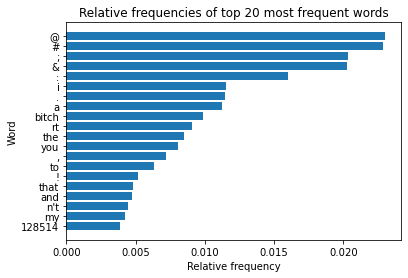

In [30]:
# Generate a list of the most frequent 2000 words
word_features = []
words = {}
all_words = nltk.FreqDist(w.lower() for k in tokens.keys() for w in tokens[k])
for label in labels:
    words[label] = nltk.FreqDist(w.lower() for k in tokens.keys() for w in tokens[k])
    word_features = word_features + list(words[label])[:750]

# Create list of top 20 most frequent words; reverse it for the bar graph
x = [word for word in list(all_words)[:20]]
y = [all_words.freq(word) for word in x]
x.reverse()
y.reverse()

# Bar graph
plt.barh(width=y, y=x)
plt.xlabel('Relative frequency')
plt.ylabel('Word')
plt.title('Relative frequencies of top 20 most frequent words')
plt.show()


In [31]:
# Define function to generate document features
def document_features(document):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains({})'.format(word)] = (word in document_words)
    return features


In [32]:
# Create featuresets for each document
featuresets = [(document_features(d), c) for (d, c) in documents]


### Model Training

Partition the data into 70% training data, 30% test data. Then train the model using a naive Bayes classifier.


In [33]:
# Partition data into training and test sets
train_pct = 0.7
train_doc_ct = int(len(documents) * train_pct)
train_set, test_set = featuresets[train_doc_ct:], featuresets[:train_doc_ct]
print('Training docs:', train_doc_ct)
print('Test docs:', len(documents) - train_doc_ct)


Training docs: 17348
Test docs: 7435


In [34]:
# Train the model
classifier = nltk.NaiveBayesClassifier.train(train_set)


In [35]:
# Print out accuracy for reference, even though we'll use a different set of metrics to actually evaluate the model
print(nltk.classify.accuracy(classifier, test_set))
classifier.show_most_informative_features(5)


0.8322573207286142
Most Informative Features
         contains(bitch) = True           offens : neithe =    115.5 : 1.0
           contains(ass) = True           hate_s : neithe =     84.1 : 1.0
          contains(hoes) = True           offens : neithe =     49.9 : 1.0
        contains(nigger) = True           hate_s : neithe =     45.6 : 1.0
         contains(pussy) = True           offens : neithe =     40.1 : 1.0


### Evaluate Test Set

Evaluate the test set by comparing reference labels against predicted labels. Precision, recall, and F1 scores were calculated for each label. A confusion matrix had to be generated manually because of an error in the NLTK ConfusionMatrix function.


In [36]:
# Evaluate test data

# Create empty reference and test sets
refsets = {}
testsets = {}
for label in list(dfgrp['label']):
    refsets[label] = set()
    testsets[label] = set()

# Populate reference and test sets with reference and predicted labels
for i, (feats, label) in enumerate(test_set):
    refsets[label].add(i)
    observed = classifier.classify(feats)
    testsets[observed].add(i)


In [37]:
# model metrics

# Show precision and recall
f1_scores = []
for label in list(dfgrp['label']):
    print(label + ':')
    p1 = precision(refsets[label], testsets[label])
    r1 = recall(refsets[label], testsets[label])
    f1 = 2 / ((1/p1) + (1/r1))
    f1_scores.append(f1)
    print('\tprecision=' + str(p1))
    print('\trecall=' + str(r1))
    print('\tf1-score=' + str(f1))
print()

# Generate confusion matrix (the nltk ConfusionMatrix function generated an error, so I had to do this manually)
row = []
for label1 in refsets:
    col = []
    for label2 in testsets:
        ct = len(list(set(refsets[label1]) & set(testsets[label2])))    # find intersection of the two sets
        col.append(ct)
    row.append(col)
cm = np.matrix(row)
print('Confusion matrix:')
print('Actual values in rows ' + str([label for label in list(dfgrp['label'])]))
print('Predicted values in columns ' + str([label for label in list(dfgrp['label'])]))
print(cm)
print()

# Find geometric mean of F1 scores
ttl = 1
for f1 in f1_scores:
    ttl *= f1
f1_geom_mean = ttl ** (1 / len(f1_scores))
print('Geometric mean of F1 scores:', f1_geom_mean)


hate_speech:
	precision=0.3628048780487805
	recall=0.1171259842519685
	f1-score=0.17708333333333334
neither:
	precision=0.6895705521472393
	recall=0.5809786354238456
	f1-score=0.6306340003740416
offensive_language:
	precision=0.8667581475128645
	recall=0.9406552494415488
	f1-score=0.9021960364220674

Confusion matrix:
Actual values in rows ['hate_speech', 'neither', 'offensive_language']
Predicted values in columns ['hate_speech', 'neither', 'offensive_language']
[[  119   147   750]
 [   24  1686  1192]
 [  185   612 12633]]

Geometric mean of F1 scores: 0.4653202952624098


### Analysis and Conclusions

